# Graph mappings

In [1]:
import os

import xarray as xr
import numpy as np

from sklearn.neighbors import NearestNeighbors

import torch
from torch_geometric.data import HeteroData
import torch_geometric

import h3


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
era_res = 96
grid_type = "o" # n or o

## Data -> OXXX

In [4]:
# reference data retrieved via mars
# retrieve,
# class=ea,
# date=2010-01-01,
# expver=1,
# levelist=1,
# levtype=sfc,
# grid=o96,
# stream=oper,
# time=00:00:00,
# type=an,
# param=2t,
# target='/home/mlx/data/gribs/o96.grib

era = xr.load_dataset(f"/home/mlx/data/gribs/{grid_type}{era_res}.grib", engine="cfgrib")
era

<xarray.Dataset>
Dimensions:     (values: 542080)
Coordinates:
    number      int64 0
    time        datetime64[ns] 2010-01-01
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    latitude    (values) float64 89.78 89.78 89.78 ... -89.78 -89.78 -89.78
    longitude   (values) float64 0.0 20.0 40.0 60.0 ... 280.0 300.0 320.0 340.0
    valid_time  datetime64[ns] 2010-01-01
Dimensions without coordinates: values
Data variables:
    t2m         (values) float32 248.0 248.2 248.4 248.6 ... 246.5 246.7 246.8
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-11-22T10:31 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
era.latitude

<xarray.DataArray 'latitude' (values: 542080)>
array([ 89.78487691,  89.78487691,  89.78487691, ..., -89.78487691,
       -89.78487691, -89.78487691])
Coordinates:
    number      int64 0
    time        datetime64[ns] 2010-01-01
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    latitude    (values) float64 89.78 89.78 89.78 ... -89.78 -89.78 -89.78
    longitude   (values) float64 0.0 20.0 40.0 60.0 ... 280.0 300.0 320.0 340.0
    valid_time  datetime64[ns] 2010-01-01
Dimensions without coordinates: values
Attributes:
    units:          degrees_north
    standard_name:  latitude
    long_name:      latitude

In [6]:
era.longitude

<xarray.DataArray 'longitude' (values: 542080)>
array([  0.,  20.,  40., ..., 300., 320., 340.])
Coordinates:
    number      int64 0
    time        datetime64[ns] 2010-01-01
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    latitude    (values) float64 89.78 89.78 89.78 ... -89.78 -89.78 -89.78
    longitude   (values) float64 0.0 20.0 40.0 60.0 ... 280.0 300.0 320.0 340.0
    valid_time  datetime64[ns] 2010-01-01
Dimensions without coordinates: values
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude

In [7]:
era.latitude.size, era["t2m"].size

(542080, 542080)

In [8]:
grid_n_lons = era["t2m"].GRIB_pl
tlat = grid_n_lons.shape[0]
mlon = grid_n_lons.max()
area_weights = []
nind = 0

for i in range(tlat):
    nlon = grid_n_lons[i]
    area = np.cos(np.deg2rad(era.latitude[nind].data))*mlon/nlon
    area_weights.extend([area]*nlon)
    nind+=nlon
print(len(area_weights),era.latitude.size)

assert(len(area_weights)==era.latitude.size)

542080 542080


In [9]:
# only works for oct. grid
# area_weights = []
# nind = 0
# nlon = 20
# tlat = era_res
# mlon = 4*tlat+16
# for i in range(tlat):
#     area = np.cos(np.deg2rad(era.latitude[nind].data))*mlon/nlon
#     area_weights.extend([area]*nlon)
#     #print(era.latitude[nind].data,era.longitude[nind].data,area)
#     nind+=nlon
#     nlon+=4
# area_weights.extend(area_weights[::-1])
# print(len(area_weights),era.latitude.size)

# assert(len(area_weights)==era.latitude.size)

In [10]:
len(area_weights), np.array(area_weights).sum()

(542080, 521927.4341052072)

In [11]:
era.longitude.min(), era.longitude.max()

(<xarray.DataArray 'longitude' ()>
 array(0.)
 Coordinates:
     number      int64 0
     time        datetime64[ns] 2010-01-01
     step        timedelta64[ns] 00:00:00
     surface     float64 0.0
     valid_time  datetime64[ns] 2010-01-01,
 <xarray.DataArray 'longitude' ()>
 array(359.71875)
 Coordinates:
     number      int64 0
     time        datetime64[ns] 2010-01-01
     step        timedelta64[ns] 00:00:00
     surface     float64 0.0
     valid_time  datetime64[ns] 2010-01-01)

In [12]:
era.latitude.min(), era.latitude.max()

(<xarray.DataArray 'latitude' ()>
 array(-89.78487691)
 Coordinates:
     number      int64 0
     time        datetime64[ns] 2010-01-01
     step        timedelta64[ns] 00:00:00
     surface     float64 0.0
     valid_time  datetime64[ns] 2010-01-01,
 <xarray.DataArray 'latitude' ()>
 array(89.78487691)
 Coordinates:
     number      int64 0
     time        datetime64[ns] 2010-01-01
     step        timedelta64[ns] 00:00:00
     surface     float64 0.0
     valid_time  datetime64[ns] 2010-01-01)

In [13]:
elat = np.array(era["latitude"])
elon = np.array(era["longitude"])
ecoords = np.stack([elat, elon], axis=-1).reshape((-1, 2))
ecoords_sp = np.deg2rad(ecoords)
print(f"dcoords_sp.shape = {ecoords_sp.shape}")

dcoords_sp.shape = (542080, 2)


In [14]:
NUM_ERA_NEIGHBORS = 3 # this is never used, we could put 3 here to speed up graph generation

eneigh = NearestNeighbors(n_neighbors=NUM_ERA_NEIGHBORS, metric="haversine", n_jobs=4)
eneigh.fit(ecoords_sp)

eadjmat = eneigh.kneighbors_graph(ecoords_sp, NUM_ERA_NEIGHBORS, mode="distance").tocoo()
print(f"eadjmat.shape = {eadjmat.shape}")

eadjmat.shape = (542080, 542080)


In [15]:
eadjmat

<542080x542080 sparse matrix of type '<class 'numpy.float64'>'
	with 1626240 stored elements in COOrdinate format>

In [16]:
from sklearn.preprocessing import normalize
eadjmat_norm = normalize(eadjmat, norm="l1", axis=1)
eadjmat_norm.data = 1.0 - eadjmat_norm.data

In [17]:
era2era_key = ("era", "to", "era")

era2era_gdata = {
    # we should swap rows and cols here. It does not matter too much since the
    # adjacency matrix is symmetric but better be consistent
    "edge_index": torch.from_numpy(np.stack([eadjmat.col, eadjmat.row], axis=0).astype(np.int64)),
    "edge_attr": torch.from_numpy(np.expand_dims(eadjmat_norm.data, axis=-1).astype(np.float32)),
    "ecoords_rad": torch.from_numpy(ecoords_sp.astype(np.float32)),
    "info": f"o{era_res}_to_o{era_res} graph",
    'area_weights':torch.from_numpy(np.array(area_weights)),
}

In [18]:

resolution = 2 # no multi mesh

luse_multi_mesh = True
# grid_flavour = 1 ; resolution = 2 # use H3 grid
grid_flavour = 2 ; resolution = 5 #4 #5 #6 # uses trimesh

NUM_H3_NEIGHBORS = 7 # this is only relevant if luse_multi_mesh=False

if luse_multi_mesh:

    from aifs.utils.graph_gen import multi_mesh1, multi_mesh2
    import networkx as nx

    # for developement / debugging
    # import sys
    # from importlib import reload
    # multi_mesh1 = reload(sys.modules["aifs.utils.graph_gen"]).multi_mesh1
    # multi_mesh2 = reload(sys.modules["aifs.utils.graph_gen"]).multi_mesh2

    h3_resolutions = tuple([x for x in range(resolution+1)]) # resolution of h3 grids
    resolution = "_".join([str(x) for x in h3_resolutions])

    if grid_flavour == 1:
        H3 = multi_mesh1(h3_resolutions, self_loop=False, flat=True, neighbour_children=False, depth=None)
        # H3 = multi_mesh1(h3_resolutions, self_loop=False, flat=True, neighbour_children=True, depth=1)
        h3_grid = [node for node in H3.nodes]
        hcoords = np.array([h3.h3_to_geo(val) for val in h3_grid])
        hcoords_sp = np.deg2rad(hcoords)
    else:
        H3, hcoords_sp = multi_mesh2(h3_resolutions)

    print(H3.number_of_nodes(), H3.number_of_edges())

    print(list(H3.nodes())[0:6])
    print(list(H3.edges())[0:6])
    print(H3.nodes[list(H3.nodes())[0]])
    print(H3.edges[list(H3.edges())[0]])

    hneigh = NearestNeighbors(  # this is used later for the era -> h and h -> era mapper
        n_neighbors=NUM_H3_NEIGHBORS,
        metric="haversine",
        n_jobs=4
    )
    hneigh.fit(hcoords_sp)

    hadjmat = nx.to_scipy_sparse_array(H3, format='coo')

else:

    h3_grid = [h3.geo_to_h3(lat, lon, resolution) for lat, lon in ecoords]
    h3_grid = sorted(set(h3_grid))
    hcoords = np.array([h3.h3_to_geo(val) for val in h3_grid])
    hcoords_sp = np.deg2rad(hcoords)
    
    hneigh = NearestNeighbors(
        n_neighbors=NUM_H3_NEIGHBORS,
        metric="haversine",
        n_jobs=4,
    )
    hneigh.fit(hcoords_sp)

    hadjmat = hneigh.kneighbors_graph(hcoords_sp, NUM_H3_NEIGHBORS, mode="distance").tocoo()

print("-------------------")
hcoords_sp.shape, hadjmat

10242 81900
[18, 3382, 3390, 8936, 5912, 9334]
[(18, 3382), (18, 3390), (18, 8936), (18, 5912), (18, 9334), (18, 6310)]
{'hcoords_rad': array([1.5707964, 0.       ], dtype=float32)}
{'weight': 0.034598426022827575}
-------------------


((10242, 2),
 <10242x10242 sparse array of type '<class 'numpy.float64'>'
 	with 81900 stored elements in COOrdinate format>)

In [19]:
min_hidden_grid_dist, max_hidden_grid_dist = hadjmat.data.min(), hadjmat.data.max()
min_hidden_grid_dist, max_hidden_grid_dist

(0.03459826329235959, 1.107148885639973)

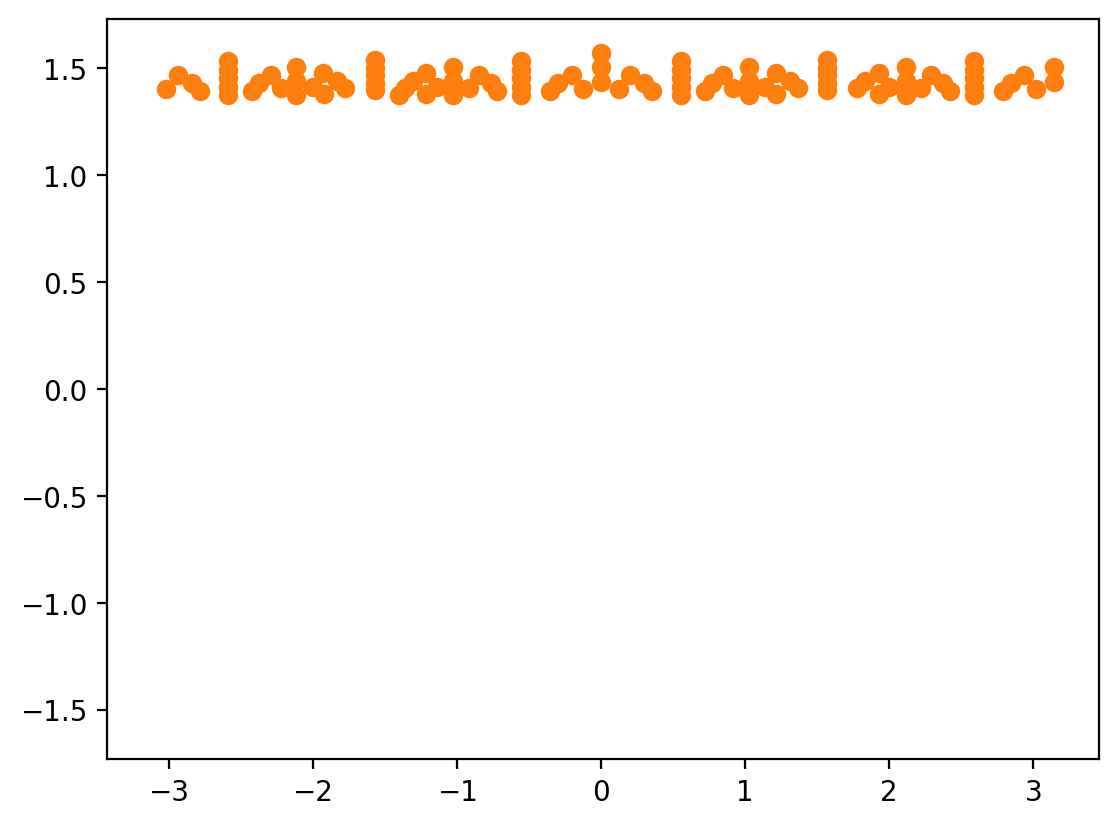

In [20]:
slice1 = slice(0, 100)
plt.scatter(hcoords_sp[...,1], hcoords_sp[..., 0], color='C0', alpha=0.001)
plt.scatter(hcoords_sp[slice1,1], hcoords_sp[slice1, 0], color='C1', alpha=1)

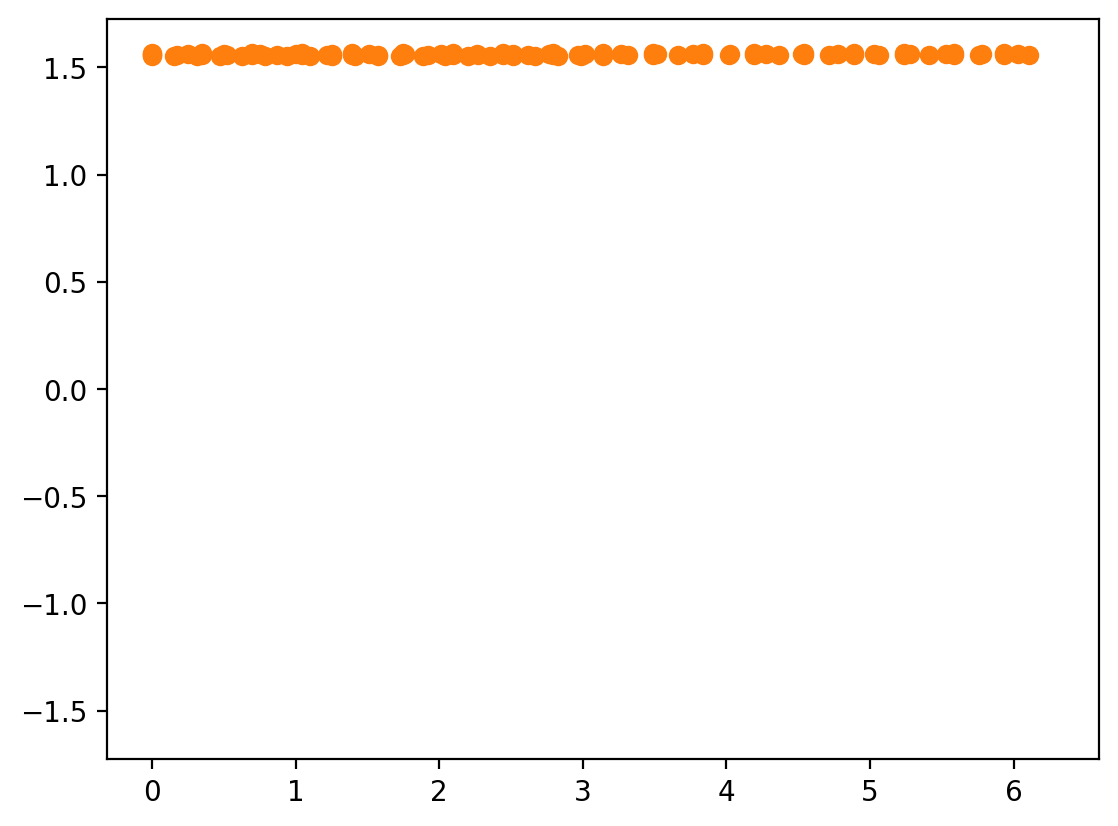

In [21]:
slice1 = slice(0, 100)
plt.scatter(ecoords_sp[...,1], ecoords_sp[..., 0], color='C0', alpha=0.001)
plt.scatter(ecoords_sp[slice1,1], ecoords_sp[slice1, 0], color='C1', alpha=1)

In [44]:
# Visualisation
if luse_multi_mesh and False:
    from aifs.utils.graph_gen import plot_graph_from_networkx
    plot_graph_from_networkx('H Graph', H3)


In [23]:
hadjmat_norm = normalize(hadjmat, norm="l1", axis=1)
hadjmat_norm.data = 1.0 - hadjmat_norm.data
hadjmat_norm

<10242x10242 sparse array of type '<class 'numpy.float64'>'
	with 81900 stored elements in Compressed Sparse Row format>

In [24]:
h2h_key = ("h", "to", "h")

h2h_gdata = {
    # we should swap rows and cols here. It does not matter too much since the
    # adjacency matrix is symmetric but better be consistent
    "edge_index": torch.from_numpy(np.stack([hadjmat.col, hadjmat.row], axis=0).astype(np.int64)),
    "edge_attr": torch.from_numpy(np.expand_dims(hadjmat_norm.data, axis=-1).astype(np.float32)),
    "hcoords_rad": torch.from_numpy(hcoords_sp.astype(np.float32)),
    "info": "h3_to_h3 graph",
}

In [25]:
# compute mappings
NUM_H_TO_ERA_NEIGHBORS = 3
NUM_ERA_TO_H_NEIGHBORS = 12

cutoff_encoder = True #False

# ERA -> H3 aka the "encoder"
if cutoff_encoder:
    RADIUS_EARTH=6371
    H_CUTOFF = RADIUS_EARTH*min_hidden_grid_dist*0.7 #160. #150. 
    print(f"using cut-off radius of {H_CUTOFF}")
    RADIUS_H_TO_ERA=H_CUTOFF/RADIUS_EARTH

    era_to_h3_adjmat = eneigh.radius_neighbors_graph(
        hcoords_sp,
        radius=RADIUS_H_TO_ERA,
    ).tocoo()

else:
    era_to_h3_adjmat = eneigh.kneighbors_graph(
        hcoords_sp,
        n_neighbors=NUM_ERA_TO_H_NEIGHBORS,
        mode="distance",
    ).tocoo()

# H3 -> ERA aka the "decoder"
h3_to_era_adjmat = hneigh.kneighbors_graph(
    ecoords_sp,
    n_neighbors=NUM_H_TO_ERA_NEIGHBORS,
    mode="distance",
).tocoo()

era_to_h3_adjmat, h3_to_era_adjmat

using cut-off radius of 154.29787480493604


(<10242x542080 sparse matrix of type '<class 'numpy.float64'>'
 	with 814480 stored elements in COOrdinate format>,
 <542080x10242 sparse matrix of type '<class 'numpy.float64'>'
 	with 1626240 stored elements in COOrdinate format>)

In [26]:
h3_to_era_adjmat_norm = normalize(h3_to_era_adjmat, norm="l1", axis=1)
h3_to_era_adjmat_norm.data = 1.0 - h3_to_era_adjmat_norm.data

era_to_h3_adjmat_norm = normalize(era_to_h3_adjmat, norm="l1", axis=1)
era_to_h3_adjmat_norm.data = 1.0 - era_to_h3_adjmat_norm.data

era_to_h3_adjmat_norm, h3_to_era_adjmat_norm

(<10242x542080 sparse matrix of type '<class 'numpy.float64'>'
 	with 814480 stored elements in Compressed Sparse Row format>,
 <542080x10242 sparse matrix of type '<class 'numpy.float64'>'
 	with 1626240 stored elements in Compressed Sparse Row format>)

In [27]:
era_h_has_isolated = torch_geometric.utils.contains_isolated_nodes(torch_geometric.utils.from_scipy_sparse_matrix(era_to_h3_adjmat_norm)[0])
h_era_has_isolated = torch_geometric.utils.contains_isolated_nodes(torch_geometric.utils.from_scipy_sparse_matrix(h3_to_era_adjmat_norm)[0])
h_h_has_isolated = torch_geometric.utils.contains_isolated_nodes(torch_geometric.utils.from_scipy_sparse_matrix(hadjmat_norm)[0])

print(f"era to h has isolated nodes: {era_h_has_isolated}")
print(f"h to era has isolated nodes: {h_era_has_isolated}")
print(f"h to h has isolated nodes: {h_h_has_isolated}")

assert era_h_has_isolated == False and h_era_has_isolated == False and h_h_has_isolated == False

era to h has isolated nodes: False
h to era has isolated nodes: False
h to h has isolated nodes: False


In [28]:
h2e_key = ("h", "to", "era")

h2e_gdata = {
    # we should swap rows and cols here. It does not matter too much since the
    # adjacency matrix is symmetric but better be consistent
    "edge_index": torch.from_numpy(np.stack([h3_to_era_adjmat.col, h3_to_era_adjmat.row], axis=0).astype(np.int64)),
    "edge_attr": torch.from_numpy(np.expand_dims(h3_to_era_adjmat_norm.data, axis=-1).astype(np.float32)),
    "hcoords_rad": torch.from_numpy(hcoords_sp.astype(np.float32)),
    "ecoords_rad": torch.from_numpy(ecoords_sp.astype(np.float32)),
    "info": "h3_to_era graph",
}

In [29]:
e2h_key = ("era", "to", "h")

e2h_gdata = {
    # we should swap rows and cols here. It does not matter too much since the
    # adjacency matrix is symmetric but better be consistent
    "edge_index": torch.from_numpy(np.stack([era_to_h3_adjmat.col, era_to_h3_adjmat.row], axis=0).astype(np.int64)),
    "edge_attr": torch.from_numpy(np.expand_dims(era_to_h3_adjmat_norm.data, axis=-1).astype(np.float32)),
    "hcoords_rad": torch.from_numpy(hcoords_sp.astype(np.float32)),
    "ecoords_rad": torch.from_numpy(ecoords_sp.astype(np.float32)),
    "info": "era_to_h3 graph",
}

In [30]:
graphs_normed = HeteroData(
    {
       era2era_key : era2era_gdata,
       h2h_key: h2h_gdata,
       e2h_key : e2h_gdata,
       h2e_key : h2e_gdata,
    }
)

# Add directionality attribute

In [31]:
from aifs.utils.graph_gen import directional_edge_features, directional_edge_features_rotated

luse_rotated_edge_features = True

if luse_rotated_edge_features:
    edge_directions_func = directional_edge_features_rotated # relative to target node rotated to north pole
else:
    edge_directions_func = directional_edge_features # loc target node - loc source node


In [32]:
hhedge_dirs = []
for n in range(graphs_normed[("h", "to", "h")]['edge_index'].shape[1]):
    i,j = graphs_normed[("h", "to", "h")]['edge_index'][:,n]
    ic = graphs_normed[("h", "to", "h")]['hcoords_rad'][i,:]
    jc = graphs_normed[("h", "to", "h")]['hcoords_rad'][j,:]
    hhedge_dirs.append(edge_directions_func(ic, jc))
hhedge_dirs = torch.from_numpy(np.stack(hhedge_dirs).astype(np.float32))
hhedge_attr = torch.concat([graphs_normed[("h", "to", "h")]['edge_attr'],hhedge_dirs],axis=-1)

In [33]:
ehedge_dirs = []
for n in range(graphs_normed[("era", "to", "h")]['edge_index'].shape[1]):
    i,j = graphs_normed[("era", "to", "h")]['edge_index'][:,n]
    ic = graphs_normed[("era", "to", "h")]['ecoords_rad'][i,:]
    jc = graphs_normed[("era", "to", "h")]['hcoords_rad'][j,:]
    ehedge_dirs.append(edge_directions_func(ic, jc))
ehedge_dirs = torch.from_numpy(np.stack(ehedge_dirs).astype(np.float32))
ehedge_attr = torch.concat([graphs_normed[("era", "to", "h")]['edge_attr'],ehedge_dirs],axis=-1)

In [34]:
heedge_dirs = []
for n in range(graphs_normed[("h", "to", "era")]['edge_index'].shape[1]):
    i,j = graphs_normed[("h", "to", "era")]['edge_index'][:,n]
    ic = graphs_normed[("h", "to", "era")]['hcoords_rad'][i,:]
    jc = graphs_normed[("h", "to", "era")]['ecoords_rad'][j,:]
    heedge_dirs.append(edge_directions_func(ic, jc))
heedge_dirs = torch.from_numpy(np.stack(heedge_dirs).astype(np.float32))
heedge_attr = torch.concat([graphs_normed[("h", "to", "era")]['edge_attr'],heedge_dirs],axis=-1)

In [35]:
eeedge_dirs = []
for n in range(graphs_normed[("era", "to", "era")]['edge_index'].shape[1]):
    i,j = graphs_normed[("era", "to", "era")]['edge_index'][:,n]
    ic = graphs_normed[("era", "to", "era")]['ecoords_rad'][i,:]
    jc = graphs_normed[("era", "to", "era")]['ecoords_rad'][j,:]
    eeedge_dirs.append(edge_directions_func(ic, jc))
eeedge_dirs = torch.from_numpy(np.stack(eeedge_dirs).astype(np.float32))
eeedge_attr = torch.concat([graphs_normed[("era", "to", "era")]['edge_attr'],eeedge_dirs],axis=-1)

In [36]:
graphs_normed[("h", "to", "era")]['edge_attr'] = heedge_attr
graphs_normed[("h", "to", "h")]['edge_attr'] = hhedge_attr
graphs_normed[("era", "to", "h")]['edge_attr'] = ehedge_attr
graphs_normed[("era", "to", "era")]['edge_attr'] = eeedge_attr

# Plot Graphs

In [37]:
# plot graphs
lplot_graphs = False

from aifs.utils.graph_gen import plot_graph_from_graphdata, plot_bipartite_from_graphdata

if lplot_graphs:
    plot_graph_from_graphdata("H Graph", graphs_normed[("h", "to", "h")], 'hcoords_rad')

    # n_h3_nodes0 = 122
    # n_h3_nodes1 = 842
    # print(sorted(node_adjacencies, reverse=True)[0:n_h3_nodes0])
    # print(sorted(node_adjacencies, reverse=True)[n_h3_nodes0:n_h3_nodes0+n_h3_nodes1])
    # print(sorted(node_adjacencies, reverse=True)[n_h3_nodes0+n_h3_nodes1:n_h3_nodes0+n_h3_nodes1+100])

In [38]:


if lplot_graphs:
    plot_bipartite_from_graphdata("ERA to H Graph", "blue", graphs_normed[("era", "to", "h")], ('ecoords_rad', 'hcoords_rad'), graphs_normed[("era", "to", "h")]['ecoords_rad'], graphs_normed[("era", "to", "h")]['hcoords_rad'])


In [39]:
if lplot_graphs:
    plot_bipartite_from_graphdata("H to ERA Graph", "red", graphs_normed[("h", "to", "era")], ('hcoords_rad', 'ecoords_rad'), graphs_normed[("h", "to", "era")]['ecoords_rad'], graphs_normed[("h", "to", "era")]['hcoords_rad'])  

In [40]:
graphs_normed[("era", "to", "h")]['edge_attr'].shape

torch.Size([814480, 3])

# Save Graphs

In [41]:
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
timestamp

'20231122105126'

In [42]:
# output_dir = "/ec/res4/hpcperm/nesl/gnn/new_graphs/"
# torch.save(graphs_normed, os.path.join(output_dir, f"graph_mappings_normed_edge_attrs_ordered_desc_lat_lon_{timestamp}_{grid_type}{era_res}_h_{resolution}.pt"))

In [43]:
!ls -lt $HPCPERM/gnn/new_graphs

total 1834424
-rw-r----- 1 nesl rd 133764984 Nov 22 10:51 graph_mappings_normed_edge_attrs_ordered_desc_lat_lon_20231122105126_n320_h_0_1_2_3_4_5.pt
-rw-r----- 1 nesl rd 141385272 Nov 22 10:25 graph_mappings_normed_edge_attrs_ordered_desc_lat_lon_20231122102529_n320_h_0_1_2_3_4_5_6.pt
-rw-r----- 1 nesl rd  10403000 Nov 22 09:43 graph_mappings_normed_edge_attrs_ordered_desc_lat_lon_20231122094352_o96_h_0_1_2_3_4.pt
-rw-r----- 1 nesl rd  12292152 Nov 22 09:39 graph_mappings_normed_edge_attrs_ordered_desc_lat_lon_20231122093910_o96_h_0_1_2_3_4_5.pt
-rw-r----- 1 nesl rd  11211704 Nov 21 13:04 graph_mappings_normed_edge_attrs_20231121130414_o96_h_o32.pt
-rw-r----- 1 nesl rd  12486520 Nov 21 12:58 graph_mappings_normed_edge_attrs_20231121125800_o96_h_n48.pt
-rw-r----- 1 nesl rd  11921208 Nov 21 12:52 graph_mappings_normed_edge_attrs_20231121125206_o96_h_o48.pt
-rw-r----- 1 nesl rd 133764984 Nov  6 12:45 graph_mappings_normed_edge_attrs_ordered_lat_lon_20231106124520_n320_h_0_1_2_3_4_5.pt
-rw